# The basic CPU pipeline to process standard parallel-beam tomographic data in HTTomo:
1. Load the raw data
2. Apply 3D dezinger filter from HTTomo
3. Normalise the data, take the negative log
4. Perform stripes removal
5. Find the Center of Rotation (CoR)
6. Reconstruct using the Gridrec algorithm
7. Save the result as tiffs

Note: This pipeline uses some methods from the [TomoPy](https://tomopy.readthedocs.io/ "TomoPy documentation") software

In [35]:
import sys
from datetime import datetime
import os
from os import mkdir
import matplotlib.pyplot as plt
import yaml
import pprint

from mpi4py import MPI
import numpy as np
from nvtx import annotate
import multiprocessing
import tomopy

from httomo.common import PipelineTasks
from httomo.data.hdf.loaders import standard_tomo
from httomo.data.hdf._utils.save import intermediate_dataset
from httomo.data.hdf._utils.reslice import reslice

In [37]:
# load the corresponding YAML configuration ftask ile which can be excecuted through the HTTomo task runner
pipeline = yaml.safe_load(open('../../pipeline_template_examples/02_basic_cpu_pipeline_tomo_standard.yaml'))
pp = pprint.PrettyPrinter(indent=1)

# set paths to tomo_standard 
current_dir = os.getcwd()
in_file = os.path.join(current_dir, "../../../testdata" ,"tomo_standard.nxs")
run_out_dir_main = os.path.join(current_dir, "../../../testdata" ,"output_temp")
run_out_dir = os.path.join(current_dir, "../../../testdata" ,"output_temp", f"{datetime.now().strftime('%d-%m-%Y_%H_%M_%S')}_output")

comm = MPI.COMM_WORLD
if comm.rank == 0:
    if not os.path.exists(run_out_dir_main):
        os.makedirs(run_out_dir_main)    
    mkdir(run_out_dir)    
if comm.size == 1:
    ncore = multiprocessing.cpu_count() # use all available CPU cores if not an MPI run

{'data_path': 'entry1/tomo_entry/data/data',
 'dimension': 1,
 'image_key_path': 'entry1/tomo_entry/instrument/detector/image_key',
 'name': 'tomo',
 'pad': 0,
 'preview': [None, None, None]}
The full dataset shape is (220, 128, 160)
[0] Pad values are (0, 0).
/home/algol/Documents/DEV/HTTomo/samples/jupyter_notebooks/general/../../../testdata/tomo_standard.nxs
entry1/tomo_entry/data/data
0:180, :, :
[0] Data shape is (180, 128, 160) of type uint16


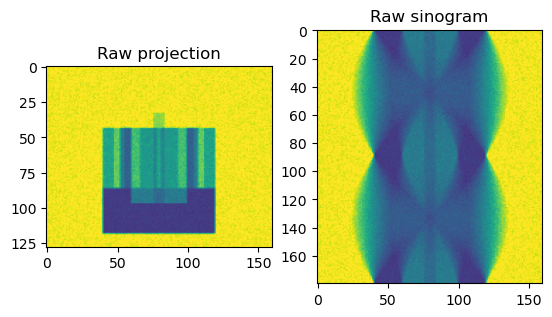

In [38]:
# getting the dictionaries from the YAML template file
standard_tomo_params = pipeline[0]['httomo.data.hdf.loaders']['standard_tomo']
pp.pprint(standard_tomo_params) # print parameters from the YAML template

# loading the data
data, flats, darks, angles, angles_total, detector_y, detector_x = standard_tomo(standard_tomo_params['name'],
                                                                                 in_file, 
                                                                                 standard_tomo_params['data_path'],
                                                                                 standard_tomo_params['image_key_path'],
                                                                                 standard_tomo_params['dimension'],
                                                                                 standard_tomo_params['preview'],
                                                                                 standard_tomo_params['pad'],
                                                                                 comm)

plt.figure()
plt.subplot(121)
plt.imshow(data[90,:,:], vmin = 0.0, vmax = 1000)
plt.title('Raw projection')
plt.subplot(122)
plt.imshow(data[:,90,:], vmin = 0.0, vmax = 1000)
plt.title('Raw sinogram')
plt.show()

{'data_in_multi': ['tomo', 'flats', 'darks'],
 'data_out_multi': ['tomo', 'flats', 'darks'],
 'mu_dezinger': 0.1,
 'radius_kernel': 1}


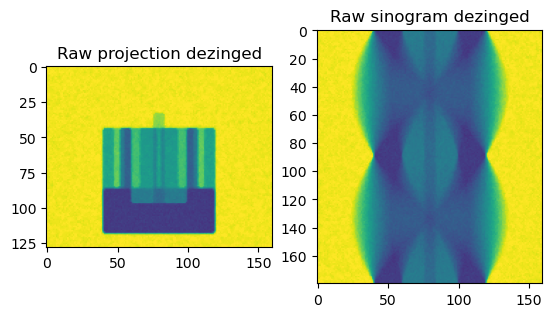

In [39]:
# Apply 3d dezinger filter from HTTomo to raw data/flats/darks
# here you will also need to get global statistics of the input data for the filter
from httomo.misc.corr import dezinger_filter3d
from httomo._stats.globals import min_max_mean_std

dezinger_params = pipeline[1]['httomo.misc.corr']['dezinger_filter3d']
pp.pprint(dezinger_params) # print parameters from the YAML template

# get global stats for each of the datasets (glob_stats[3] is a std)
glob_stats = min_max_mean_std(data, comm)
data = dezinger_filter3d(data, glob_stats, dezinger_params['radius_kernel'], dezinger_params['mu_dezinger'], ncore=ncore)

glob_stats = min_max_mean_std(flats, comm)
flats = dezinger_filter3d(flats, glob_stats, dezinger_params['radius_kernel'], dezinger_params['mu_dezinger'], ncore=ncore)

glob_stats = min_max_mean_std(darks, comm)
darks = dezinger_filter3d(darks, glob_stats, dezinger_params['radius_kernel'], dezinger_params['mu_dezinger'], ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(data[90,:,:], vmin = 0.0, vmax = 1000)
plt.title('Raw projection dezinged')
plt.subplot(122)
plt.imshow(data[:,90,:], vmin = 0.0, vmax = 1000)
plt.title('Raw sinogram dezinged')
plt.show()

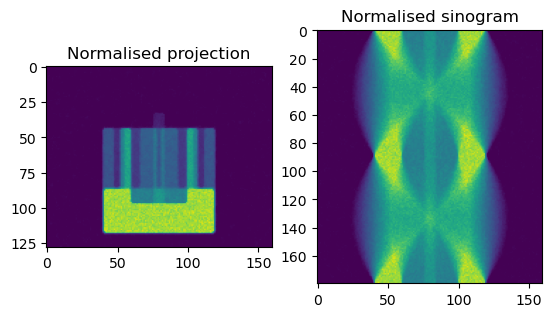

In [40]:
# Normalising raw data using TomoPy functions
from tomopy.prep.normalize import normalize, minus_log

data = normalize(data, flats, darks, ncore=ncore, cutoff=10)
data[data == 0.0] = 1e-09
data = tomopy.minus_log(data, ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(data[90,:,:], vmin = 0.0, vmax = 2.0)
plt.title('Normalised projection')
plt.subplot(122)
plt.imshow(data[:,90,:], vmin = 0.0, vmax = 2.0)
plt.title('Normalised sinogram')
plt.show()

In [41]:
# Save intermediate dataset and reslice to change chunking from projection to sinogram
data, dimension = reslice(data, run_out_dir, standard_tomo_params['dimension'], angles_total, detector_y, detector_x, comm)

/home/algol/Documents/DEV/HTTomo/samples/jupyter_notebooks/general/../../../testdata/output_temp/16-11-2022_21_59_55_output/intermediate.h5
/data
:,:,:


{'data_in': 'tomo',
 'data_out': 'tomo',
 'level': None,
 'pad': True,
 'sigma': 2,
 'wname': 'db5'}


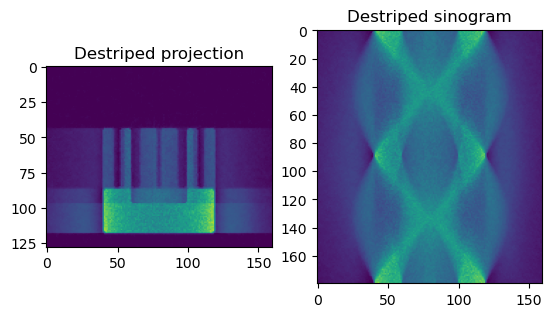

In [42]:
# Apply a stripe removal method (as all TomoPy methods are exposed, one can select a desirable one)
from tomopy.prep.stripe import remove_stripe_fw

stripe_params = pipeline[4]['tomopy.prep.stripe']['remove_stripe_fw']
pp.pprint(stripe_params) # print parameters from the YAML template

data_destriped = remove_stripe_fw(data,
                                  stripe_params['level'],
                                  stripe_params['wname'],
                                  stripe_params['sigma'],
                                  stripe_params['pad'],                                  
                                  ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(data_destriped[90,:,:], vmin = 0.0, vmax = 2.0)
plt.title('Destriped projection')
plt.subplot(122)
plt.imshow(data_destriped[:,90,:], vmin = 0.0, vmax = 2.0)
plt.title('Destriped sinogram')
plt.show()

In [43]:
# Finding the center of rotation (CoR)
from tomopy.recon.rotation import find_center_vo

cor_params = pipeline[5]['tomopy.recon.rotation']['find_center_vo']
pp.pprint(cor_params) # print parameters from the YAML template

rot_center = 0
mid_rank = int(round(comm.size / 2) + 0.1)
if comm.rank == mid_rank:
    mid_slice = int(np.size(data, 1) / 2)
    rot_center = find_center_vo(data_destriped, 
                                mid_slice, 
                                cor_params['smin'],
                                cor_params['smax'],
                                cor_params['srad'],
                                cor_params['step'],
                                cor_params['ratio'],
                                cor_params['drop'],
                                ncore=ncore)
rot_center = comm.bcast(rot_center, root=mid_rank)
print(f"Found CoR {rot_center}", comm)

{'data_in': 'tomo',
 'data_out': 'cor',
 'drop': 20,
 'ind': None,
 'ratio': 0.5,
 'smax': 50,
 'smin': -50,
 'srad': 6,
 'step': 0.25}
Found CoR 79.5 <mpi4py.MPI.Intracomm object at 0x7f68c08e9c90>


{'algorithm': 'gridrec',
 'center': 'cor',
 'data_in': 'tomo',
 'data_out': 'tomo',
 'init_recon': None,
 'sinogram_order': False}


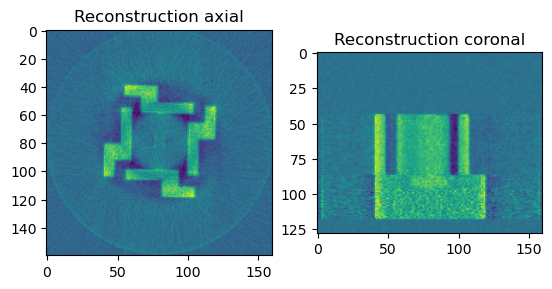

In [44]:
# Reconstructing the data using Gridrec algorithm
from tomopy.recon.algorithm import recon

rec_params = pipeline[6]['tomopy.recon.algorithm']['recon']
pp.pprint(rec_params) # print parameters from the YAML template

reconstruction = recon(data_destriped,
                       angles,
                       rot_center,
                       rec_params['sinogram_order'],                    
                       rec_params['algorithm'],                       
                       ncore=ncore)

plt.figure()
plt.subplot(121)
plt.imshow(reconstruction[50,:,:])
plt.title('Reconstruction axial')
plt.subplot(122)
plt.imshow(reconstruction[:,100,:])
plt.title('Reconstruction coronal')
plt.show()

In [46]:
# saving the resulting dataset to images
from httomo.misc.images import save_to_images

save_params = pipeline[7]['httomo.misc.images']['save_to_images']
pp.pprint(save_params) # print parameters from the YAML template

glob_stats = min_max_mean_std(reconstruction, comm) # get global stats
save_to_images(reconstruction, "recon", run_out_dir, glob_stats, comm)

{'axis': 0,
 'bits': 8,
 'data_in': 'tomo',
 'file_format': 'tif',
 'jpeg_quality': 95,
 'out_folder_name': 'recon'}
